In [2]:
####Source: https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import BartTokenizer, BartForSequenceClassification
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

D:\transformers\lib\site-packages\pytorch_lightning\metrics\__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [3]:
df = pd.read_csv('intent_data_model.csv',encoding='latin1')

train_df, val_df = train_test_split(df, test_size=0.15)
train_df.shape, val_df.shape

((680, 14), (121, 14))

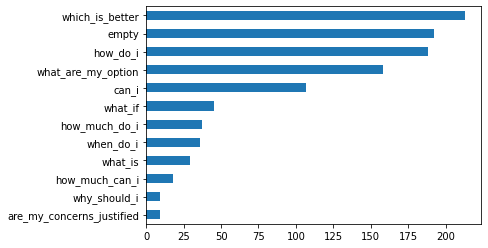

In [4]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [5]:
BART_MODEL_NAME = 'sismetanin/mbart_large-financial_phrasebank'
tokenizer = BartTokenizer.from_pretrained(BART_MODEL_NAME)

# model = BartForSequenceClassification.from_pretrained('sismetanin/mbart_large-financial_phrasebank')

In [6]:
sample_row = df.iloc[16]
sample_comment = sample_row.question
sample_labels = sample_row[LABEL_COLUMNS]

In [7]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=256,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
print(encoding.keys())
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

dict_keys(['input_ids', 'attention_mask'])
torch.Size([1, 256]) torch.Size([1, 256])


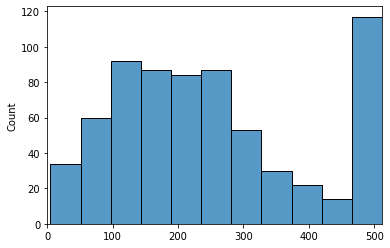

In [8]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["question"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [9]:
MAX_TOKEN_COUNT = 64

In [10]:
class IntentDataset(Dataset):
    def __init__(self,data: pd.DataFrame,tokenizer: BartTokenizer,max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row.question
        labels = data_row[LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(comment_text,add_special_tokens=True,max_length=self.max_token_len,
                                              return_token_type_ids=False,padding="max_length",truncation=True,
                                              return_attention_mask=True,return_tensors='pt')
        return dict(comment_text=comment_text,
                    input_ids=encoding["input_ids"].flatten(),
                    attention_mask=encoding["attention_mask"].flatten(),
                    labels=torch.FloatTensor(labels))

In [11]:
train_dataset = IntentDataset(train_df,tokenizer,max_token_len=MAX_TOKEN_COUNT)

In [12]:
bert_model = BartForSequenceClassification.from_pretrained(BART_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=0)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 64]), torch.Size([8, 64]))

In [13]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
# output.last_hidden_state.shape, output.pooler_output.shape


In [52]:
len(output[2][:,0])

8

In [14]:
pooled_output = output[0][:,0]

In [15]:
pooled_output

tensor([-3.1924, -2.0324, -2.9468, -3.2543, -2.3969,  0.9607, -3.5103, -2.7435],
       grad_fn=<SelectBackward>)

In [16]:
class IntentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    def setup(self, stage=None):
        self.train_dataset = IntentDataset(self.train_df,self.tokenizer,self.max_token_len)
        self.test_dataset = IntentDataset(self.test_df,self.tokenizer,self.max_token_len)
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=0)
    def val_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,num_workers=0)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,num_workers=0)

In [17]:
N_EPOCHS = 100
BATCH_SIZE = 12
data_module = IntentDataModule(train_df,val_df,tokenizer,batch_size=BATCH_SIZE,max_token_len=MAX_TOKEN_COUNT)

In [34]:
class IntentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BartForSequenceClassification.from_pretrained(BART_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output[2][:,0])
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {'val_loss': loss}
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.n_warmup_steps,
                                                    num_training_steps=self.n_training_steps)
        return dict(optimizer=optimizer,lr_scheduler=dict(scheduler=scheduler,interval='step'))

In [ ]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_training_steps)
learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [19]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [20]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1120, 5600)

In [35]:
model = IntentTagger(n_classes=len(LABEL_COLUMNS),n_warmup_steps=warmup_steps,n_training_steps=total_training_steps)

In [36]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.4775, 0.4909, 0.4845, 0.5151, 0.5111, 0.5157, 0.4965, 0.4998, 0.4940,
         0.4922, 0.5057, 0.4829],
        [0.4777, 0.4892, 0.4831, 0.5146, 0.5127, 0.5154, 0.4973, 0.5001, 0.4945,
         0.4901, 0.5077, 0.4813],
        [0.4780, 0.4898, 0.4843, 0.5151, 0.5115, 0.5155, 0.4978, 0.5000, 0.4945,
         0.4894, 0.5062, 0.4834],
        [0.4783, 0.4898, 0.4835, 0.5152, 0.5122, 0.5154, 0.4977, 0.5005, 0.4943,
         0.4912, 0.5064, 0.4825],
        [0.4782, 0.4880, 0.4821, 0.5140, 0.5139, 0.5152, 0.4982, 0.5005, 0.4946,
         0.4896, 0.5088, 0.4803],
        [0.4786, 0.4900, 0.4837, 0.5154, 0.5126, 0.5152, 0.4975, 0.5004, 0.4945,
         0.4909, 0.5063, 0.4824],
        [0.5026, 0.5066, 0.5120, 0.5114, 0.4825, 0.5020, 0.4993, 0.5007, 0.4944,
         0.5075, 0.5019, 0.5067],
        [0.4777, 0.4895, 0.4836, 0.5149, 0.5123, 0.5149, 0.4977, 0.5003, 0.4942,
         0.4904, 0.5068, 0.4818]], grad_fn=<SigmoidBackward>)

In [39]:
model

IntentTagger(
  (bert): BartForSequenceClassification(
    (model): BartModel(
      (shared): Embedding(50265, 1024, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0): BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm):

In [ ]:
criterion = nn.BCELoss()
criterion(predictions, sample_batch["labels"])

In [ ]:
# checkpoint_callback = ModelCheckpoint(
#   dirpath="/root/Aditya/",
#   filename="best-checkpoint",
#   save_top_k=1,
#   verbose=True,
#    monitor="val_loss",
#   mode="min"
# )

In [ ]:
logger = TensorBoardLogger("IntentQA_logsB", name="questions-model")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
trainer = pl.Trainer(logger=logger,
                     checkpoint_callback=True,
                     callbacks=[early_stopping_callback],
                     max_epochs=N_EPOCHS,
                     gpus=1,
                     progress_bar_refresh_rate=10)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trained_model = IntentTagger.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,
                                                  n_classes=len(LABEL_COLUMNS))
trained_model.eval()
trained_model.freeze()

In [ ]:
print(trainer.checkpoint_callback.best_model_path)

In [ ]:
test_comment = "I have 2 options, either invest in gold or in NASDAQ, what should i do?"
encoding = tokenizer.encode_plus(test_comment,
                                 add_special_tokens=True,
                                 max_length=512,
                                 return_token_type_ids=False,
                                 padding="max_length",
                                 return_attention_mask=True,
                                 return_tensors='pt')

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    print(f"{label}: {prediction}")

In [ ]:
#### evaluation
val_df1 = val_df
val_df = train_df

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = IntentDataset(val_df, tokenizer,max_token_len=MAX_TOKEN_COUNT)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device))
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
THRESHOLD = 0.3
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")

for i, name in enumerate(LABEL_COLUMNS):
    try:
        tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
        print(f"{name}: {tag_auroc}")
    except:
        print(f"{name}:", " no record")
        pass

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(y_true,y_pred,target_names=LABEL_COLUMNS,
zero_division=0))

In [ ]:
### metrics on validation data
#### evaluation

val_df = val_df1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = IntentDataset(val_df, tokenizer,max_token_len=MAX_TOKEN_COUNT)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device))
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
THRESHOLD = 0.3
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")

for i, name in enumerate(LABEL_COLUMNS):
    try:
        tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
        print(f"{name}: {tag_auroc}")
    except:
        print(f"{name}:", " no record")
        pass

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(y_true,y_pred,target_names=LABEL_COLUMNS,
zero_division=0))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, predicted_proba[:, -1])

optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]